Notes: Stage 1 is Candidate Generation. This step using TF-IDF and Cosine Similarity to Filter top 100 foods.

## **Import Library**

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
from autocorrect import Speller
import numpy as np
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('./dataset/preprocessed_recipes.csv')

In [3]:
df.head(2)

,NameClean,DescriptionClean,KeywordsClean,RecipeCategoryClean,ImagesClean,RecipeIngredientPartsClean,RecipeInstructionsClean,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,Combined
0,lowfat berry blue frozen dessert,make share lowfat berry blue frozen dessert re...,"dessert, low protein, low cholesterol, healthy...",frozen dessert,['https://img.sndimg.com/food/image/upload/w_5...,"blueberry, granulated sugar, vanilla yogurt, l...","toss 2 ups berry sugar, let stand 45 minutes, ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,lowfat berry blue frozen dessertmake share low...
1,carina tofuvegetable kebab,dish best prepared day advance allow ingredien...,"beans, vegetable, low cholesterol, weeknight, ...","soy, tofu",['https://img.sndimg.com/food/image/upload/w_5...,"extra firm tofu, eggplant, zuhini, mushrooms, ...","drain tofu, arefully squeezing ex water, pat d...",536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,carina tofuvegetable kebabdish best prepared d...


# **Stage 0: Filtering KNN**

## Training Model

In [4]:
scaler=StandardScaler()

In [5]:
df.iloc[:,7:16]

,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2
1,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3
2,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3
3,228.0,7.1,1.7,24.5,281.8,37.5,0.5,24.7,4.2
4,4.3,0.0,0.0,0.0,0.7,1.1,0.2,0.2,0.1
...,...,...,...,...,...,...,...,...,...
297329,141.7,4.0,0.3,0.0,11.7,22.4,5.3,10.0,5.2
297330,422.3,28.6,12.6,106.0,634.7,14.1,1.4,5.7,27.3
297331,84.3,2.1,1.2,6.8,15.7,16.6,0.4,15.4,0.6
297332,358.9,19.8,10.5,103.1,323.4,41.5,0.8,24.8,4.8


In [6]:
df_normalize=scaler.fit_transform(df.iloc[:,7:16].to_numpy())
df_normalize

array([[-0.57435282, -0.93065141, -0.78443089, ...,  0.1490317 ,
         2.35699622, -0.69535695],
       [ 1.53949653,  1.14525383, -0.0688011 , ...,  3.94558602,
         2.56549736,  1.2472655 ],
       [-0.96389844, -1.13341425, -1.12793319, ...,  0.4815766 ,
         0.9852782 , -0.61348397],
       ...,
       [-1.07561063, -0.96927291, -0.81305608, ..., -0.73775472,
         0.73288209, -0.88887489],
       [ 0.51382811,  0.73972816,  1.84908673, ..., -0.62690641,
         1.76441404, -0.57626898],
       [ 0.2689874 ,  0.03488591,  1.01895617, ..., -0.62690641,
         1.54493915, -0.64325596]])

In [7]:
neigh = NearestNeighbors(metric='cosine',algorithm='brute')
neigh.fit(df_normalize)

NearestNeighbors(algorithm='brute', metric='cosine')

In [8]:
transformer = FunctionTransformer(neigh.kneighbors,kw_args={'return_distance':False})
pipeline=Pipeline([('std_scaler',scaler),('NN',transformer)])

In [9]:
params={'n_neighbors':10,'return_distance':False}
pipeline.get_params()
pipeline.set_params(NN__kw_args=params)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('NN',
                 FunctionTransformer(func=<bound method KNeighborsMixin.kneighbors of NearestNeighbors(algorithm='brute', metric='cosine')>,
                                     kw_args={'n_neighbors': 10,
                                              'return_distance': False}))])

## Testing Model

In [10]:
pipeline.transform(df.iloc[:,7:16].to_numpy())[0]

array([     0, 278264,  93876,  18098, 132117, 122151, 241076, 211089,
       235618, 237022])

In [12]:
df.iloc[pipeline.transform(df.iloc[:,7:16].to_numpy())[0]]

,NameClean,DescriptionClean,KeywordsClean,RecipeCategoryClean,ImagesClean,RecipeIngredientPartsClean,RecipeInstructionsClean,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,Combined
0,lowfat berry blue frozen dessert,make share lowfat berry blue frozen dessert re...,"dessert, low protein, low cholesterol, healthy...",frozen dessert,['https://img.sndimg.com/food/image/upload/w_5...,"blueberry, granulated sugar, vanilla yogurt, l...","toss 2 ups berry sugar, let stand 45 minutes, ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,lowfat berry blue frozen dessertmake share low...
278264,glazed pineapple cinnamon creme fraiche,make share glazed pineapple cinnamon creme fra...,"pineapple, tropial fruits, fruit, caribbean, 3...",dessert,['https://img.sndimg.com/food/image/upload/w_5...,"lime, honey, ground innamon, ground nutmeg, po...",mix lime juie half lime zest 1 tablespoon hone...,172.5,2.2,1.2,5.0,19.8,41.5,3.8,32.4,1.4,glazed pineapple cinnamon creme fraichemake sh...
93876,lemon float punch,make share lemon float punch recipe foodcom,"beverages, lemon, citrus, fruit, low protein, ...",punch beverage,['character(0'],"lemon, sugar, water, ginger ale, lemon, fresh ...",combine lemon juie sugar stir dissolve sugar a...,158.4,1.7,0.9,0.4,38.6,40.1,4.0,31.1,1.9,lemon float punchmake share lemon float punch ...
18098,l b concoction,"june 22nd, 2002, feeling creative effort rewar...",15 min,beverage,['character(0'],"strawberry, strawberry, milk, blueberries, grapes","blend frozen strawberries, ie ubes, yogurt, mi...",167.3,2.0,1.0,5.7,26.2,38.4,3.0,29.9,3.1,l b concoctionjune 22nd 2002 feeling creative ...
132117,blueberry mango smoothie,make share blueberry mango smoothie recipe foo...,"beverages, 15 mins, easy",smoothy,['https://img.sndimg.com/food/image/upload/w_5...,"vanilla-flavored soymilk, frozen blueberries, ...",plae ingredient blender blend smooth,147.5,0.4,0.1,0.0,2.9,39.5,4.2,34.9,0.9,blueberry mango smoothiemake share blueberry m...
122151,blueberry orange smoothie,make share blueberry orange smoothie recipe fo...,"beverages, low protein, low cholesterol, healt...",smoothy,['character(0'],"blueberry, fresh blueberries","combine first 5 ingredient blender, puree thik...",179.4,2.6,1.3,0.7,34.3,38.1,3.0,30.4,3.1,blueberry orange smoothiemake share blueberry ...
241076,preserved apple pie filling,got hand williams sonoma art preserving cookbo...,"apple, fruit, large groups, 4 hour",dessert,['character(0'],"apple, bottled lemon juie, sugar, ground innamon","set large pot water boil, pour 12 lemon juie l...",161.3,0.3,0.1,0.0,3.6,42.2,3.8,36.4,0.4,preserved apple pie fillinggot hand williams s...
211089,rustic applesauce,combination sweet braeburns tart granny smith ...,"fruit, low protein, low cholesterol, healthy, ...",apple,['character(0'],"braeburn apples, granny smith apples, brown su...",combine first 8 ingredient duth oven medium he...,152.7,1.8,1.0,5.9,31.6,36.1,3.7,30.2,0.5,rustic applesaucecombination sweet braeburns t...
235618,berry compote,dish made ahead make great company dish also g...,"60 mins, easy",dessert,['character(0'],"fresh blueberries, fresh raspberry, granulated...","plae peahes blueberry 1 quart asserole dish, m...",161.5,0.5,0.0,0.0,0.5,40.7,3.9,36.5,1.6,berry compotedish made ahead make great compan...
237022,mango orange cooler,make share mango orange cooler recipe foodcom,"mango, tropial fruits, fruit, caribbean, afria...",beverage,['https://img.sndimg.com/food/image/upload/w_5...,"mango, limes, sparkling water, mint sprig","peel mango ut muh flesh an, add orange juie ie...",166.7,0.9,0.2,0.0,4.9,41.6,3.9,33.9,2.5,mango orange coolermake share mango orange coo...


## KNN

Accuracy: 0.945
Precision: [0.48       0.92929293 1.        ]
Recall: [1.         0.95833333 0.        ]
F1 Score: 0.9435897435897436
ROC AUC Score: 0.9455128205128206
Confusion Matrix:
 [[97  7]
 [ 4 92]]


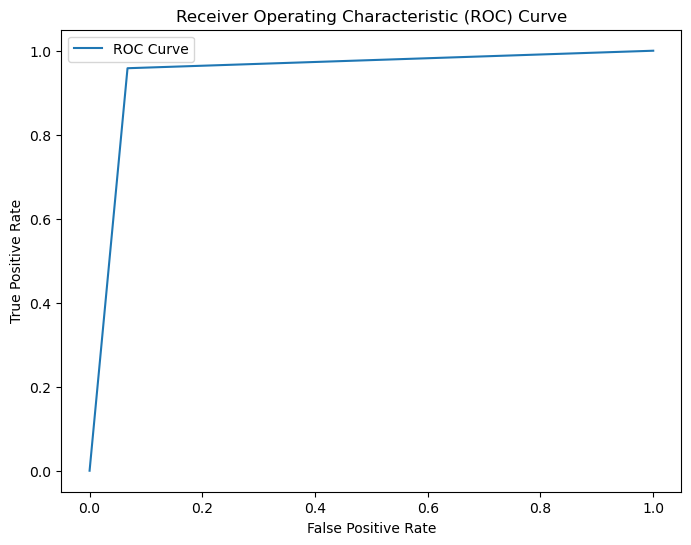

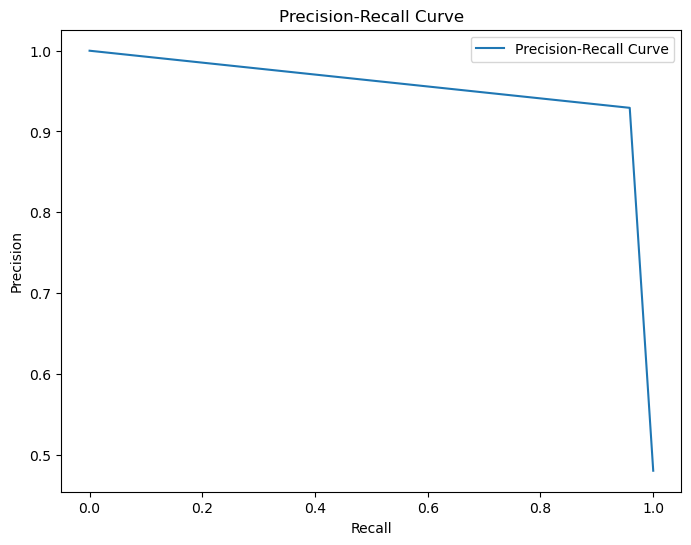

In [13]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a k-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [87]:
def scaling(dataframe):
    scaler=StandardScaler()
    prep_data=scaler.fit_transform(dataframe.iloc[:,7:16].to_numpy())
    return prep_data,scaler

def nn_predictor(prep_data):
    neigh = NearestNeighbors(metric='cosine',algorithm='brute')
    neigh.fit(prep_data)
    return neigh

def build_pipeline(neigh,scaler,params):
    transformer = FunctionTransformer(neigh.kneighbors,kw_args=params)
    pipeline=Pipeline([('std_scaler',scaler),('NN',transformer)])
    return pipeline

def extract_data(dataframe,ingredient_filter,max_nutritional_values):
    extracted_data=dataframe.copy()
    for column,maximum in zip(extracted_data.columns[7:16],max_nutritional_values):
        extracted_data=extracted_data[extracted_data[column]<maximum]
    if ingredient_filter!=None:
        for ingredient in ingredient_filter:
            extracted_data=extracted_data[extracted_data['RecipeIngredientPartsClean'].str.contains(ingredient,regex=False)]
    return extracted_data

def apply_pipeline(pipeline,_input,extracted_data):
    return extracted_data.iloc[pipeline.transform(_input)[0]]

def recommend(dataframe,_input,max_nutritional_values,ingredient_filter=None,params={'return_distance':False, 'n_neighbors': 100}):
    extracted_data=extract_data(dataframe,ingredient_filter,max_nutritional_values)
    prep_data,scaler=scaling(extracted_data)
    neigh=nn_predictor(prep_data)
    pipeline=build_pipeline(neigh,scaler,params)
    return apply_pipeline(pipeline,_input,extracted_data)

In [88]:
# https://www.dietaryguidelines.gov/
max_Calories=1000

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_fat=100

# https://www.heart.org/
max_daily_Saturatedfat=13

# https://www.dietaryguidelines.gov/
max_daily_Cholesterol=300

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Sodium=2300

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Carbohydrate=325

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Fiber=40

# https://www.heart.org/
max_daily_Sugar=40

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Protein=200

max_list=[max_Calories,max_daily_fat,max_daily_Saturatedfat,max_daily_Cholesterol,max_daily_Sodium,max_daily_Carbohydrate,max_daily_Fiber,max_daily_Sugar,max_daily_Protein]

In [89]:
test_input=df.iloc[1:2,7:16].to_numpy()

In [90]:
recommend(df,test_input,max_list)

,NameClean,DescriptionClean,KeywordsClean,RecipeCategoryClean,ImagesClean,RecipeIngredientPartsClean,RecipeInstructionsClean,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,Combined
1,carina tofuvegetable kebab,dish best prepared day advance allow ingredien...,"beans, vegetable, low cholesterol, weeknight, ...","soy, tofu",['https://img.sndimg.com/food/image/upload/w_5...,"extra firm tofu, eggplant, zuhini, mushrooms, ...","drain tofu, arefully squeezing ex water, pat d...",536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,carina tofuvegetable kebabdish best prepared d...
38936,mole coloradito oaxaca,make share mole coloradito oaxaca recipe foodcom,"mexian, weeknight, 4 hour",sauce,['character(0'],"dried anho hiles, raisins, bittersweet hoolate...","mole paste cut hiles open vertially, remove st...",614.4,25.8,2.5,0.0,1807.5,87.3,23.1,29.7,24.1,mole coloradito oaxacamake share mole coloradi...
93881,citrus salad peanut butter dressing,prepare salad hour prevent avocado browning ad...,"healthy, 30 min",low cholesterol,['character(0'],"red onion, radish, anned blak beans, avoado, m...",prepare salad soak red onion radish old water ...,460.4,25.1,4.4,23.8,1115.3,43.7,10.9,20.1,21.8,citrus salad peanut butter dressingprepare sal...
130228,sweet bourbon baked bean,make share sweet bourbon baked bean recipe foo...,"potluk, summer, sweet, 60 min",bean,['https://img.sndimg.com/food/image/upload/w_5...,"baon, onion, kidney beans, dark molasses, dark...","preheat oven 350, cook baon risp, drain set as...",552.8,18.5,6.0,25.7,1611.6,74.6,15.0,30.7,19.7,sweet bourbon baked beanmake share sweet bourb...
128540,stove top bean bake,another variation theme adapted taste one pot ...,"low cholesterol, healthy, 60 mins, beginner co...",bean,['https://img.sndimg.com/food/image/upload/w_5...,"lean baon, tomato puree, tomato paste, brown s...",cook baon onion low heat till baon rispy onion...,605.2,25.5,6.6,23.1,1216.5,68.3,17.4,26.1,33.0,stove top bean bakeanother variation theme ada...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283978,noodle chicken lasagna,make share noodle chicken lasagna recipe foodcom,"meat, european, egg free, free of, 4 hours, ea...",one dish meal,['https://img.sndimg.com/food/image/upload/w_5...,"boneless skinless hiken breasts, eggplant, low...","1 plae 12 saue pan peppers,onion,garli,and oni...",444.1,12.7,4.1,56.9,1503.2,50.9,11.9,30.8,32.0,noodle chicken lasagnamake share noodle chicke...
30128,katherine oxtail stew,oxtail one cut doesnt seem popular however ste...,"weeknight, 4 hour",stew,['character(0'],"onion, garli, ginger, tomato paste, turnip, sw...","trim ex fat oxtail, large pot duth oven, fry o...",706.7,11.8,2.1,0.0,2145.0,135.2,25.8,39.2,22.6,katherine oxtail stewoxtail one cut doesnt see...
8995,chunky chili con carne,make share chunky chili con carne recipe foodcom,"mexian, weeknight, 4 hour",meat,['character(0'],"ground beef, onion, water, tomato paste, red k...","medium skillet mediumhigh heat, brown beef oni...",588.8,19.0,7.1,77.1,1573.7,71.7,15.4,29.0,38.5,chunky chili con carnemake share chunky chili ...
127336,fivebean bake,make share fivebean bake recipe foodcom,"beans, low cholesterol, healthy, 4 hour",black bean,['character(0'],"baon, onion, blak beans, hikpeas, kidney beans...",cook hopped baon slies large skillet mediumhig...,554.8,13.6,4.3,23.2,1456.9,89.7,19.3,21.9,23.1,fivebean bakemake share fivebean bake recipe f...


In [93]:
def recommend_by_calories(dataframe, max_daily_calories, max_nutritional_values, ingredient_filter=None, params={'return_distance':False, 'n_neighbors': 100}):
    # Extract data based on maximum nutritional values and ingredient filter
    extracted_data = extract_data(dataframe, ingredient_filter, max_nutritional_values)

    # Scale the data
    prep_data, scaler = scaling(extracted_data)

    # Fit the Nearest Neighbors model
    neigh = nn_predictor(prep_data)

    # Build the pipeline
    pipeline = build_pipeline(neigh, scaler, params)

    # Create a test input with specified calories
    test_input = np.array([[0] * 9])  # Assuming the input shape is (1, 9) for 9 nutritional features
    test_input[0, 0] = max_daily_calories  # Set the calories (assuming the first feature is calories)
    test_input[0, 1] = 100  # Set the remaining features to 0

    # Get recipe recommendation based on test input
    recommended_recipe = apply_pipeline(pipeline, test_input, extracted_data)

    return recommended_recipe


In [97]:
filtered_recipe_calories = recommend_by_calories(df, 400, max_list)
filtered_recipe_calories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 215256 to 68014
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NameClean                   100 non-null    object 
 1   DescriptionClean            100 non-null    object 
 2   KeywordsClean               100 non-null    object 
 3   RecipeCategoryClean         100 non-null    object 
 4   ImagesClean                 100 non-null    object 
 5   RecipeIngredientPartsClean  100 non-null    object 
 6   RecipeInstructionsClean     100 non-null    object 
 7   Calories                    100 non-null    float64
 8   FatContent                  100 non-null    float64
 9   SaturatedFatContent         100 non-null    float64
 10  CholesterolContent          100 non-null    float64
 11  SodiumContent               100 non-null    float64
 12  CarbohydrateContent         100 non-null    float64
 13  FiberContent                100 n

# **Stage 1: Candidate Generation**
## **Content-Based Filtering**

*Desc:*

Similar items, such as Reels about dogs, are close together in the embedding space. The candidate generator works as follows:
- given a user, the system looks for items that are close to them in the embedding space.
- The notion of “closeness” is defined by a similarity measure


*Vectorization:*

For dietary food recommender system, TF-IDF is the most suitable method because it effectively highlights important ingredients and instructions, capturing the essence of the recipes better than binary features or BoW.

*Similarity:*

For dietary food recommender system, Cosine Similarity is the most appropriate choice due to its effectiveness in handling high-dimensional sparse data, such as TF-IDF vectors. It focuses on the direction of the vectors rather than their magnitude, making it robust for text-based features.

## User Input

In [ ]:
user_favorite_foods = ['fish', 'beef']

# Generate combinations for similarity calculations
user_favorites = user_favorite_foods + [' '.join(user_favorite_foods)]

In [ ]:
user_favorites

['fish', 'beef', 'fish beef']

## Vectorization: TF-IDF & Cosine Similarity

TF-IDF: Converts text into numerical vectors by capturing term importance within a document and across the corpus.

In [ ]:
df_combined=df["Combined"]
df_combined

0         blueberry granulated sugar vanilla yogurt lemo...
1         extra firm tofu eggplant zuhini mushrooms soy ...
2         plain tomato juie abbage onion arrots elerycab...
3         sugar margarine egg flour salt buttermilk grah...
4         butter brown sugar granulated sugar vanilla ex...
                                ...                        
261440    self-rising flour shortening milk buttermilk s...
261441    salted butter all-purpose flour iing sugar whi...
261442    hamburger onion elery water hestnut dried dill...
261443    all-purpose flour brown sugar butter ground in...
261444    fresh ginger unsalted butter dark brown sugar ...
Name: Combined, Length: 261445, dtype: object

In [ ]:
# Create a TfidfVectorizer object to transform the movie genres into a Tf-idf representation
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_combined)

In [ ]:
# Create the directory if it doesn't exist
!mkdir -p ./models

# Save the TfidfVectorizer
with open('./models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save the Tfidf matrix
with open('./models/tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [ ]:
# Transform user's favorite foods to TF-IDF vector
user_favorite_vector = tfidf.transform(user_favorites)

Cosine Similarity: Measures the similarity between two vectors, providing a metric to compare documents.

In [ ]:
# Calculate the cosine similarity matrix between the food
cosine_similarities = cosine_similarity(user_favorite_vector, tfidf_matrix).flatten()

In [ ]:
# Initialize a dictionary to store similarities
similarity_dict = {}

# Calculate similarities for each string
for favorite in user_favorites:
    # Transform the string to a TF-IDF vector
    favorite_vector = tfidf.transform([favorite])

    # Calculate cosine similarities
    similarities = cosine_similarity(favorite_vector, tfidf_matrix).flatten()

    # Store the similarities in the dictionary
    similarity_dict[favorite] = similarities

In [ ]:
similarity_df = pd.DataFrame(similarity_dict, index=df_combined)
similarity_df.head(2)

,fish,beef,fish beef
Combined,,,
blueberry granulated sugar vanilla yogurt lemon juielowfat berry blue frozen desserttoss 2 ups berry sugar let stand 45 minutes stirring oasionally transfer berrysugar mixture food proessor add yogurt proess smooth strain fine sieve pour baking pan transfer ie ream maker proess aording manufaturers diretions freeze unovered edge solid entre soft transfer proessor blend smooth again return pan freeze edge solid transfer proessor blend smooth again fold remaining 2 ups blueberries pour plasti mold freeze overnight let soften slightly serve,0.0,0.0,0.0
extra firm tofu eggplant zuhini mushrooms soy saue low sodium soy saue olive oil maple syrup honey red wine vinegar lemon juie garli loves mustard powder blak peppercarina tofuvegetable kebabdrain tofu arefully squeezing ex water pat dry paper towels cut tofu oneinh squares set aside cut eggplant lengthwise half ut eah half approximately three strips cut strip rosswise oneinh ubes slie zuhini halfinh thik slies cut red pepper half removing stem seeds ut eah half oneinh squares wipe mushroom lean moist paper towel remove stems thread tofu vegetable barbeue skewer alternating olor ombinations example first piee eggplant slie tofu zuhini red pepper baby orn mushrooms continue way skewer full make marinade putting ingredient blender blend high speed one minute mixed alternatively put ingredient glass jar tightly lid shake well mixed lay kebab long shallow baking pan nonmetal tray making sure lie flat evenly pour marinade kebabs turning one tofu vegetable oated refrigerate kebab three eight hours oasionally spooning marinade them broil grill kebab 450 f 1520 minutes grill vegetable browned suggestion meal served ooked brown rie amount easily doubled make four serving,0.0,0.0,0.0


## Filter High Similarity

In [ ]:
top_n_high = 50
high_similarity_candidates = []

for favorite, similarities in similarity_dict.items():
    # Get top n indices
    top_n_indices = similarities.argsort()[-top_n_high:][::-1]

    # Select the top n candidate recipes
    candidate_recipes = df.iloc[top_n_indices].copy()
    candidate_recipes['cosine_similarity'] = similarities[top_n_indices]

    # Append the candidate DataFrame to the list
    high_similarity_candidates.append(candidate_recipes)

In [ ]:
high_similarity_df = pd.concat(high_similarity_candidates).drop_duplicates().reset_index(drop=True)

## Filter Low Random Similarity

In [ ]:
top_n_low = 5
low_similarity_candidates = []

for favorite, similarities in similarity_dict.items():
    # Get indices of foods with non-zero and low similarity
    non_zero_indices = np.where(similarities > 0)[0]
    low_similarity_indices = non_zero_indices[similarities[non_zero_indices].argsort()[:top_n_low]]

    # Select random foods from these low similarity candidates
    random_low_sim_candidates = df.iloc[low_similarity_indices].sample(top_n_low, random_state=42)
    random_low_sim_candidates['cosine_similarity'] = similarities[low_similarity_indices]

    # Append the low similarity DataFrame to the list
    low_similarity_candidates.append(random_low_sim_candidates)

In [ ]:
low_similarity_df = pd.concat(low_similarity_candidates).drop_duplicates().reset_index(drop=True)

In [ ]:
high_similarity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    150 non-null    int64  
 1   NameClean                   150 non-null    object 
 2   RecipeIngredientPartsClean  150 non-null    object 
 3   RecipeInstructionsClean     150 non-null    object 
 4   Calories                    150 non-null    float64
 5   FatContent                  150 non-null    float64
 6   SaturatedFatContent         150 non-null    float64
 7   CholesterolContent          150 non-null    float64
 8   SodiumContent               150 non-null    float64
 9   CarbohydrateContent         150 non-null    float64
 10  FiberContent                150 non-null    float64
 11  SugarContent                150 non-null    float64
 12  ProteinContent              150 non-null    float64
 13  Combined                    150 non

In [ ]:
low_similarity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    15 non-null     int64  
 1   NameClean                   15 non-null     object 
 2   RecipeIngredientPartsClean  15 non-null     object 
 3   RecipeInstructionsClean     15 non-null     object 
 4   Calories                    15 non-null     float64
 5   FatContent                  15 non-null     float64
 6   SaturatedFatContent         15 non-null     float64
 7   CholesterolContent          15 non-null     float64
 8   SodiumContent               15 non-null     float64
 9   CarbohydrateContent         15 non-null     float64
 10  FiberContent                15 non-null     float64
 11  SugarContent                15 non-null     float64
 12  ProteinContent              15 non-null     float64
 13  Combined                    15 non-nu

## Final Candidate

In [ ]:
final_candidates = pd.concat([high_similarity_df, low_similarity_df]).drop_duplicates().reset_index(drop=True)

In [ ]:
final_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    165 non-null    int64  
 1   NameClean                   165 non-null    object 
 2   RecipeIngredientPartsClean  165 non-null    object 
 3   RecipeInstructionsClean     165 non-null    object 
 4   Calories                    165 non-null    float64
 5   FatContent                  165 non-null    float64
 6   SaturatedFatContent         165 non-null    float64
 7   CholesterolContent          165 non-null    float64
 8   SodiumContent               165 non-null    float64
 9   CarbohydrateContent         165 non-null    float64
 10  FiberContent                165 non-null    float64
 11  SugarContent                165 non-null    float64
 12  ProteinContent              165 non-null    float64
 13  Combined                    165 non

# **Export Final Candidate**

In [ ]:
final_candidates.to_csv('./dataset/final_candidates.csv', index=False)

In [ ]:
high_similarity_df.to_csv('./dataset/high_similarity_df.csv', index=False)
low_similarity_df.to_csv('./dataset/low_similarity_df.csv', index=False)

In [ ]:
high_similarity_df.head(2)

,RecipeId,NameClean,RecipeIngredientPartsClean,RecipeInstructionsClean,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,Combined,cosine_similarity
0,72665,ginger chilli baked fish,"lime, fresh ginger, fish saue, fresh ginger, g...","preheat oven hot 220 degree c, make 4 deep sli...",436.4,8.8,1.6,268.0,985.1,12.2,1.2,7.9,74.3,lime fresh ginger fish saue fresh ginger garli...,0.784882
1,512673,fresh fillet sole snap,"fillets of sole, garli, salt, pepper, butter, ...","spread garli side fish, sprinkle salt pepper, ...",179.7,9.7,2.6,82.2,815.2,0.8,0.1,0.2,21.4,fillets of sole garli salt pepper butter olive...,0.730094


In [ ]:
low_similarity_df.head(2)

,RecipeId,NameClean,RecipeIngredientPartsClean,RecipeInstructionsClean,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,Combined,cosine_similarity
0,509635,julia amp jaquess deonstruted turkey corn brea...,"turkey arass, onions, onions, arrots, arrots, ...",rih turkey stok heat oil large heavybottomed p...,713.2,37.3,10.5,241.9,1232.9,9.6,1.9,4.0,75.7,turkey arass onions onions arrots arrots elery...,0.013300
1,312548,roasted vegetable ravioli crispy panetta,"egg, all-purpose flour, olive oil, zuhini, red...",basi pasta reipe start flour measure plae nie ...,637.8,19.7,4.6,269.3,703.2,86.3,5.3,5.7,23.4,egg all-purpose flour olive oil zuhini red bel...,0.019405
